In [228]:
# !pip install umap-learn

In [12]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

import umap

In [4]:
dataset = datasets.load_dataset('bookcorpus')['train']

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

dataset[:3]

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/datasets/load.py:1461: FutureWarning: The repository for bookcorpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bookcorpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

In [5]:
import numpy as np
import torch
import torch.nn as nn

class Absolute_attention(nn.Module):
  def __init__(self, dim=256, num_heads=16, hidden_dim=None, time_dim=64):
    super().__init__()

    self.dim = dim
    self.num_heads = num_heads
    self.time_dim = time_dim

    if isinstance(hidden_dim, int):
      self.hidden_dim = hidden_dim
    else:
      assert dim % num_heads == 0
      self.hidden_dim = dim // num_heads

    # assert self.hidden_dim % 2 == 0
    # self.time_embedding = time_embedding
    self.time_angle = nn.Parameter(torch.rand(self.num_heads, self.time_dim))
    self.head_time_delta = nn.Parameter(torch.rand(self.num_heads))

    self.Q = nn.Linear(dim, num_heads * (self.hidden_dim + 1))
    self.K = nn.Linear(dim, num_heads * self.hidden_dim)
    self.V = nn.Linear(dim, num_heads * self.hidden_dim)
    self.O = nn.Linear(num_heads * self.hidden_dim, dim)

    with torch.no_grad():
      self.Q.bias.copy_(torch.zeros_like(self.Q.bias))
      self.K.bias.copy_(torch.zeros_like(self.K.bias))
      self.V.bias.copy_(torch.zeros_like(self.V.bias))
      self.O.bias.copy_(torch.zeros_like(self.O.bias))

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, tensor, attention_mask):
    batch_length = tensor.shape[:2]
    # print(f'{tensor.shape=}')
    q = self.Q(tensor).view(*batch_length, self.num_heads, self.hidden_dim + 1)
    # q = (q + attention_mask[..., None, None])
    q = q.softmax(dim=-1)

    time_angles = (torch.arange(batch_length[1]).to(self.head_time_delta.device)[:, None, None]
                   + self.head_time_delta[None, :, None]) * self.time_angle  # shape: [length, num_heads, dim_time] ?
    cosines, sines = time_angles.cos(), time_angles.sin()
    time = torch.cat([cosines + sines, cosines - sines], dim=-1) / np.sqrt(self.hidden_dim)  # shape: [length, num_heads, 2*dim_time] ?
    q = q[..., :-1, None].sum(-2) * time
    # q shape: [batch_size, length, num_heads, 2*dim_time] = [batch_size, length, 1, 1] * [length, num_heads, 2*dim_time] ?

    k = self.K(tensor).view(*batch_length, self.num_heads, self.hidden_dim)  # bthd
    k = k.softmax(dim=-1) * attention_mask[..., None, None]

    k_time_angles = torch.arange(batch_length[1]).to(self.time_angle.device)[:, None, None] * self.time_angle
    k_cosines, k_sines = time_angles.cos(), time_angles.sin()
    k_time = torch.cat([k_cosines + k_sines, k_cosines - k_sines], dim=-1) / np.sqrt(self.hidden_dim)

    attention = torch.einsum('blhd,thd->blth', q, k_time)

    v = self.V(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    adding_comb = torch.einsum('blth,bthd->blhd', attention, v)

    output = self.O(adding_comb.reshape(*batch_length, self.dim))

    return self.dropout(output)

class Absolute_bert(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, attention_type=Absolute_attention, dtype=torch.float):
    super().__init__()
    self.vocab_size = vocab_size
    self.dim = dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.depth = depth

    self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.nn.init.xavier_normal_(torch.ones([vocab_size, self.dim])))
    # self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.rand(vocab_size, self.dim) / np.sqrt(self.dim))

    self.layers = nn.ModuleList([Absolute_attention(dim=dim,
      num_heads=num_heads,
      hidden_dim=hidden_dim
      ) for _ in range(depth)])
    self.dtype = dtype

  def forward(self, input_ids, attention_mask, **kwargs):
    # extended_attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
    # extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(self.dtype).min

    tensor = self.embedding(input_ids)

    for layer in self.layers:
      output = layer(tensor, attention_mask)
      tensor = tensor + output

    return tensor

class Absolute_bert_for_masked_LM(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, **kwargs):
    super().__init__()
    self.base_model = Absolute_bert(vocab_size, dim, num_heads, hidden_dim, depth, **kwargs)
    self.bias = nn.Parameter(torch.zeros(vocab_size))

  def forward(self, input_ids, attention_mask, labels=None, **kwargs):
    tensor = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    return tensor, labels

  def word_embeddings(self):
    return self.base_model.embedding.weight

subpath = '20240710.02:31:19' # sum_of_softmax
subpath = '20240710.18:31:50' # sum_of_softmax

In [6]:
import numpy as np
import torch
import torch.nn as nn

class Absolute_attention(nn.Module):
  def __init__(self, dim=256, num_heads=16, hidden_dim=None, time_dim=64):
    super().__init__()

    self.dim = dim
    self.num_heads = num_heads
    self.time_dim = time_dim

    if isinstance(hidden_dim, int):
      self.hidden_dim = hidden_dim
    else:
      assert dim % num_heads == 0
      self.hidden_dim = dim // num_heads

    # assert self.hidden_dim % 2 == 0
    # self.time_embedding = time_embedding
    self.time_angle = nn.Parameter(torch.rand(self.num_heads, self.time_dim))
    self.head_time_delta = nn.Parameter(torch.rand(self.num_heads))

    self.Q = nn.Linear(dim, num_heads * self.hidden_dim)
    self.K = nn.Linear(dim, num_heads * self.hidden_dim)
    self.V = nn.Linear(dim, num_heads * self.hidden_dim)
    self.O = nn.Linear(num_heads * self.hidden_dim, dim)

    with torch.no_grad():
      self.Q.bias.copy_(torch.zeros_like(self.Q.bias))
      self.K.bias.copy_(torch.zeros_like(self.K.bias))
      self.V.bias.copy_(torch.zeros_like(self.V.bias))
      self.O.bias.copy_(torch.zeros_like(self.O.bias))

    one = torch.zeros(self.dim)
    one[0] = 1
    self.one = nn.Parameter(one, requires_grad=False)
    self.b = nn.Parameter(torch.zeros(self.num_heads))
    
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, tensor, attention_mask):
    batch_length = tensor.shape[:2]
    # print(f'{tensor.shape=}')
    q = self.Q(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    # q = (q + attention_mask[..., None, None])
    q0 = tensor @ self.one # shape: [batch_size, length]
    q0 = q0[..., None] + self.b
    q = torch.cat([q, q0[..., None].expand(-1, -1, -1, 1)], dim=-1)
    q = q.softmax(dim=-1)
    

    time_angles = (torch.arange(batch_length[1]).to(self.head_time_delta.device)[:, None, None]
                   + self.head_time_delta[None, :, None]) * self.time_angle  # shape: [length, num_heads, dim_time] ?
    cosines, sines = time_angles.cos(), time_angles.sin()
    time = torch.cat([cosines + sines, cosines - sines], dim=-1) / np.sqrt(self.hidden_dim)  # shape: [length, num_heads, 2*dim_time] ?
    q = q[..., :-1, None].sum(-2) * time
    # q shape: [batch_size, length, num_heads, 2*dim_time] = [batch_size, length, 1, 1] * [length, num_heads, 2*dim_time] ?

    k = self.K(tensor).view(*batch_length, self.num_heads, self.hidden_dim)  # bthd
    k = k.softmax(dim=-1) * attention_mask[..., None, None]

    k_time_angles = torch.arange(batch_length[1]).to(self.time_angle.device)[:, None, None] * self.time_angle
    k_cosines, k_sines = time_angles.cos(), time_angles.sin()
    k_time = torch.cat([k_cosines + k_sines, k_cosines - k_sines], dim=-1) / np.sqrt(self.hidden_dim)

    attention = torch.einsum('blhd,thd->blth', q, k_time)

    v = self.V(tensor).view(*batch_length, self.num_heads, self.hidden_dim)
    adding_comb = torch.einsum('blth,bthd->blhd', attention, v)

    output = self.O(adding_comb.reshape(*batch_length, self.dim))

    return self.dropout(output)

class Absolute_bert(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, attention_type=Absolute_attention, dtype=torch.float):
    super().__init__()
    self.vocab_size = vocab_size
    self.dim = dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.depth = depth

    self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.nn.init.xavier_normal_(torch.ones([vocab_size, self.dim])))
    # self.embedding = nn.Embedding(vocab_size, dim, _weight=torch.rand(vocab_size, self.dim) / np.sqrt(self.dim))

    self.layers = nn.ModuleList([Absolute_attention(dim=dim,
      num_heads=num_heads,
      hidden_dim=hidden_dim
      ) for _ in range(depth)])
    self.dtype = dtype

  def forward(self, input_ids, attention_mask, **kwargs):
    # extended_attention_mask = attention_mask.to(dtype=self.dtype)  # fp16 compatibility
    # extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(self.dtype).min

    tensor = self.embedding(input_ids)

    for layer in self.layers:
      output = layer(tensor, attention_mask)
      tensor = tensor + output

    return tensor

class Absolute_bert_for_masked_LM(nn.Module):
  def __init__(self, vocab_size, dim=256, num_heads=8, hidden_dim=None, depth=8, **kwargs):
    super().__init__()
    self.base_model = Absolute_bert(vocab_size, dim, num_heads, hidden_dim, depth, **kwargs)
    self.bias = nn.Parameter(torch.zeros(vocab_size))

  def forward(self, input_ids, attention_mask, labels=None, **kwargs):
    tensor = self.base_model(input_ids=input_ids, attention_mask=attention_mask, **kwargs)

    return tensor, labels

  def word_embeddings(self):
    return self.base_model.embedding.weight

# subpath = '20240710.03:33:50' # e1_as_pivot
subpath = '20240710.15:09:00' # e1_as_pivot

In [82]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15
subpath = '20240711.03:00:33' # all1_layerNorm
subpath = '20240711.03:33:04' # all1_layerNorm, lr 2e-5
subpath = '20240711.03:33:24' # all1_layerNorm, lr 5e-6
subpath = '20240711.03:48:45' # all1_layerNorm, lr 1e-6

weight norms, min: 0.15627342462539673, max: 0.21426233649253845
min norms: ['##ically', 'roach', 'fiscal', 'charitable', 'locate', 'abandonment', 'statistical', 'spartans', '500', 'congo']
max norms: ['[unused244]', '.', '-', 'and', 'trolley', '##tiv', '[unused90]', "'", '(', ',']
bias norms, min: -0.0021625873632729053, max: 0.0034545857924968004
min norms: ['[PAD]', '[MASK]', 'pissed', '[unused87]', '##)', '[unused381]', '[unused986]', 'צ', '[unused167]', 'bellowed']
max norms: ['##a', 's', '–', 'is', 'a', 'which', 'at', 'are', 'on', 'by']


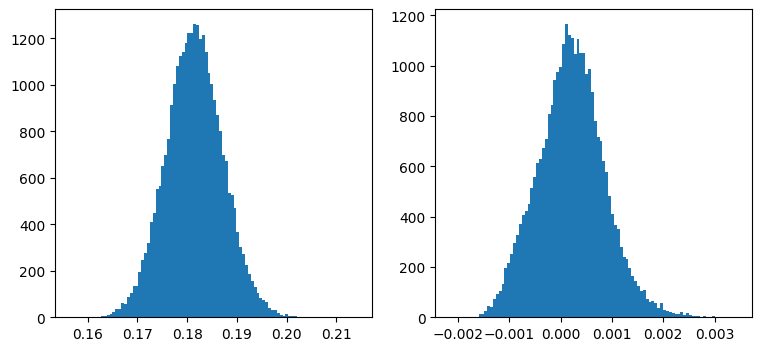

In [83]:
epoch_num = 0
batch_num = 50000


folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu')
word_reprs = model.word_embeddings().detach()

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(word_reprs, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [84]:
# %%time
from collections import defaultdict

def get_projection(representations, n_neighbors=10, methods=['euclidean', 'cosine'], n_jobs=16):
  transed_repr = {}
  for method in methods:
    reducer = umap.UMAP(n_neighbors=n_neighbors, metric=method, n_jobs=n_jobs)
    transed_repr[method] = reducer.fit_transform(representations)
  return transed_repr

def grouped_get_projection(representations_dict_groupNames, **kwargs):
  
  size_repr_len_pairs = [[name, reprs, reprs.shape[0]] for name, reprs in representations_dict_groupNames.items()]
  names, reprs, lengths = [*zip(*size_repr_len_pairs)]

  transeds = get_projection(torch.cat(reprs))
  to_return = defaultdict(defaultdict)
  for method, transed in transeds.items():
    accum_length = 0
    for name, length in zip(names, lengths):
      to_return[method][name] = transed[accum_length:accum_length+length]
      accum_length += length
    
  return to_return
  

pivot = torch.zeros(1, word_reprs.shape[1])
pivot[0, 0] = 1
origin = torch.zeros(1, word_reprs.shape[1])

transeds_dict_methods_groupNames = grouped_get_projection({'word': word_reprs, 'pivot': pivot, 'origin': origin})

# transeds_dict_methods = get_projection(torch.cat([word_reprs, pivot]))
# transed_words_dict_methods = {name: transed[:-1] for name, transed in transeds_dict_methods.items()} #transed word representations in a dict with methods as keys
# transed_pivots_dict_methods = {name: transed[-1:] for name, transed in transeds_dict_methods.items()}
vector_norms = np.linalg.norm(word_reprs, axis=1)
# del model

In [85]:
from utils.inspecting import inspect_direction_representing_words

def draw_and_annotate(ax, points, word_pos_pairs):
  image = ax.scatter(*points.T, marker='.', edgecolors='none', cmap=cmap, c=norms, alpha=.2, vmin=0)

  for word, x_y in word_pos_pairs:
    ax.annotate(word, x_y, alpha=.7)

0.0004835634

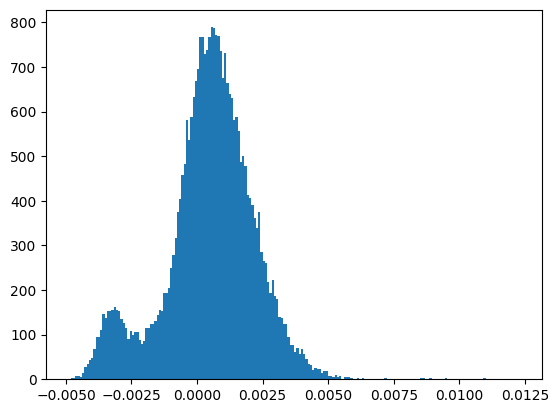

In [86]:
sim = cosine_similarity(word_reprs)
offdiag_mean = (sim.sum(axis=1) - 1) / (sim.shape[0] - 1)
plt.hist(offdiag_mean, bins=200)
offdiag_mean.mean()

In [87]:
wordIdPairs_dict_samplingMethod = {}

far_ids = np.where(offdiag_mean < -0.05)[0]
tokens = tokenizer.convert_ids_to_tokens(far_ids)
wordIdPairs_dict_samplingMethod['far_tokens'] = list(zip(tokens, far_ids))

words = ['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am']
samples = np.random.randint(0, tokenizer.vocab_size, [70])
word_ids = tokenizer.convert_tokens_to_ids(words)
sample_tokens = tokenizer.convert_ids_to_tokens(samples)
words = words + sample_tokens
ids = word_ids + samples.tolist()
wordIdPairs_dict_samplingMethod['random+most_common'] = list(zip(words, ids))
print(words, ids, sep='\n')

sampled_vecs = np.random.rand(150, word_reprs.shape[1])
sampled_args = cosine_similarity(sampled_vecs, word_reprs).argmax(axis=1)
sample_tokens = tokenizer.convert_ids_to_tokens(sampled_args)
wordIdPairs_dict_samplingMethod['random_vectors'] = list(zip(sample_tokens, sampled_args))
print(sample_tokens, sampled_args, sep='\n')

wordIdPairs_dict_samplingMethod['end_with_ed'] = [[key, id_] for key, id_ in tokenizer.vocab.items() if key[-2:] == 'ed']

['[MASK]', ',', '.', '[SEP]', '[PAD]', '[CLS]', 'the', 'and', 'and', 'i', 'her', 'he', 'him', 'she', 'are', 'is', 'they', 'a', 'am', '##青', 'sandstone', 'meetings', 'rehabilitation', 'assigned', 'auburn', 'transitioned', '##overs', 'remotely', 'fold', 'producer', 'allergic', 'sisters', '[unused77]', 'foyer', 'combo', 'neutron', 'practically', 'flush', 'anglo', 'odor', 'discharge', 'impact', 'followed', '##ower', '##ate', '##باد', 'ingrid', 'fencing', '[unused934]', '##田', 'writhing', 'scraped', '##xed', 'honest', 'whisper', '##ruff', '##iface', 'verbal', 'editors', 'mohammed', '1910', 'suffolk', 'oclc', '##eria', 'cree', '1833', 'defunct', 'リ', '##idae', 'pollen', 'sequel', 'theologians', 'fit', 'barely', 'vocational', '##ssi', 'earliest', 'guidelines', 'weiss', '##roid', 'galveston', 'join', 'cantor', 'ucla', 'berkshire', 'highlands', 'descending', 'ر', 'reverted']
[103, 1010, 1012, 102, 0, 101, 1996, 1998, 1998, 1045, 2014, 2002, 2032, 2016, 2024, 2003, 2027, 1037, 2572, 30501, 11694

In [ ]:
%%capture --no-stdout --no-display

cmap = plt.get_cmap('rainbow')

def plot_basics(axes, transeds_dict_groupNames, title_prefix=None):
  for ax, (methodName, transeds_dict_groupNames) in zip(axes, transeds_dict_methods_groupNames.items()):
    transeds_dict_groupNames = transeds_dict_groupNames.copy()
    transed_vecs = transeds_dict_groupNames.pop('word')
  
    image = ax.scatter(*transed_vecs.T, marker='.', edgecolors='none', s=3, c=norms, cmap=cmap, alpha=.7, vmin=0)
    fig.colorbar(image, ax=ax, fraction=0.05, pad=0.05)
  
    ax.scatter(*transeds_dict_groupNames['pivot'].T, marker='+', color='red', alpha=.7, label='pivot')
    ax.scatter(*transeds_dict_groupNames['origin'].T, marker='+', color='blue', alpha=.7, label='origin')
    ax.set_title(f"{title_prefix}: {methodName}")
    ax.legend()


fig, axes = plt.subplots(1+len(wordIdPairs_dict_samplingMethod), 2, figsize=[16, 6*(1+len(wordIdPairs_dict_samplingMethod))])

plot_basics(axes[0], transeds_dict_methods_groupNames, 'raw')

for axes_or_a_row, (samplingMethodName, word_id_pairs) in zip(axes[1:], wordIdPairs_dict_samplingMethod.items()):
  plot_basics(axes_or_a_row, transeds_dict_methods_groupNames, samplingMethodName)

  for ax, (ProjectingMethodName, transeds_dict_groupNames) in zip(axes_or_a_row, transeds_dict_methods_groupNames.items()):
    # print(word_id_pairs)
    for word, id_ in word_id_pairs:
      # print(word, id_)
      ax.annotate(word, transeds_dict_groupNames['word'][id_], alpha=.3)

# # fig.savefig(f'image/umap-{subpath}-epoch_{epoch_num}-{batch_num}.png')